# Data Crawl Stone Soup pt. 1: Species

I recently got back into Dungeon Crawl Stone Soup, a charming old-school roguelike. Not only is DCSS free and open source, it's a gift to an armchair data scientist like me, since it has a lot of publicly available gameplay data. Each completed game yields a 'morgue' file, which gives lots of information about the game, like what level the player reached, which god they worshipped, what was in their inventory, and so on. [Here's](http://crawl.akrasiac.org/rawdata/scone/morgue-scone-20161225-013224.txt) an example from one of my games.

I downloaded all the morgue files from one popular DCSS server, [http://crawl.akrasiac.org/](http://crawl.akrasiac.org/), and parsed out about a million games. My code is available on GitHub [here](https://github.com/colinmorris/crawl-coroner) - that includes the code for parsing morgue files, and the helpers I import in this notebook. (If you're interested in doing your own analyses of the data, shoot me an e-mail, and I'll see about hosting a tarball of the morgue files somewhere so you don't need to hammer CAO's server like I did).

In this notebook, I'll be doing some analysis involving the 26\* different species that players choose from when starting a game. I'll be using the Pandas framework throughout - if you're not interested in the coding part, feel free to just skip ahead to the graphs.

\*(This data spans 10 major versions, from 0.10 to 0.20, some of which added or removed species. I'm including all extant species in the most recent release, 0.19. This excludes species removed between 0.10 and 0.19 like sludge elves, and experimental species like lava orcs and barachians. It includes high elves, even though they're set to be removed in 0.20.)

In [1]:
%matplotlib inline
from __future__ import division
from vis_common import load_frame, plot_winrate, STORE
from crawl_data import CANON_SPECIES
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

f = load_frame(include=['saw_temple', 'saw_lair', 'saw_vaults', 'saw_zot'])
print "Loaded data frame with {} records and {} columns".format(len(f), len(f.columns))

# Some reusable indices. These are just boolean arrays I can use to index into my data
# frame to get games that were lost, or won, or quit
ilost = STORE['ilost']
iwon = STORE['iwon']
iquit = STORE['iquit']

species = f['species'].cat.categories
drac_species = [sp for sp in species if 'draconian' in sp]
idrac = f['species'].isin(drac_species)
colored_dracs = [sp for sp in drac_species if sp != 'draconian']
cdrac_index = f['species'].isin(colored_dracs)

def get_original_species(sp):
    return 'draconian' if sp in drac_species else sp
    
# The draconian species presents a little problem. When draconians hit level 7, they 
# get a random colour, and their species label changes accordingly. We'd rather lump
# black/red/green/baby draconians all into one species, or we'll get some funny results.
# (For example, the win rate for coloured draconians is very high, because of the survivor
# bias. On the other hand, baby draconians win 0% of the time, because it's basically 
# impossible to win the game before level 7.)
f['orig_species'] = f['species'].map(get_original_species)

Loaded data frame with 785200 records and 17 columns


## Pick rate

In [160]:
def xlabel_pct(ax):
    ax.set_xticklabels('{}%'.format(x*100) for x in ax.get_xticks())
    
def plot_percent(df, horizontal=False, **kwargs):
    pfunc = df.plot.barh if horizontal else df.plot.bar
    ax = pfunc(**kwargs)
    if horizontal:
        xlabel_pct(ax)
    else:
        ax.set_yticklabels('{}%'.format(y*100) for y in ax.get_yticks())
    return ax

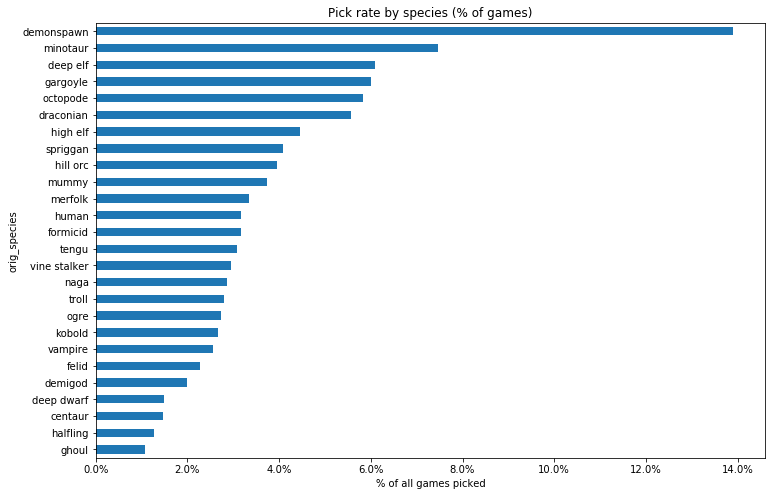

In [125]:
pr = (f.groupby('orig_species').size() / len(f)).sort_values()
ax = plot_percent(pr, True, title='Pick rate by species (% of games)', figsize=(12,8));
ax.set_xlabel('% of all games picked');

The most surprising thing here to me was just how much demonspawn exceed every other species in popularity. They're almost twice as popular as the second-place species, with an absolute difference of around 40,000 games.

The popularity of minotaurs and deep elves isn't too surprising, since they're the archetypal melee fighter and caster species, respectively. There's maybe some tendency for species with complex mechanics or heavy restrictions to be less popular, but there are lots of exceptions. (Halflings are very vanilla, and unpopular, and mummies, spriggans, and octopodes are weird but popular)

## Win rate

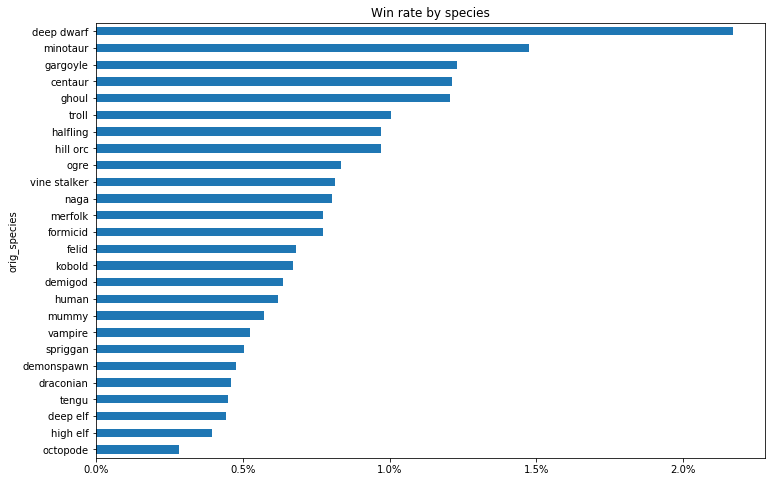

In [108]:
wr = f.groupby('orig_species')['won'].mean().dropna().sort_values()
ax = plot_percent(wr, True, title='Win rate by species', figsize=(12,8));

There's quite a lot of variation here. A random deep dwarf game is 10x as likely to be won as a random octopode game. What makes good species good and bad species bad? I'm going to focus on the two extremes cases to start.

## Why do deep dwarves win so much?

### Pakellas?

When I showed these results to a friend who plays DCSS, he suggested that maybe this was an effect of the god Pakellas being overpowered. Deep dwarves would benefit disproportionately from worshipping Pakellas because of their high evocation aptitude, and the ability to refund Heal wounds wands to overcome their lack of HP regeneration.

Pakellas was added in 0.18 and removed in 0.19, so if this is the reason, we would expect their win rate to be higher in version 0.18, and for most of their wins to come from that version.

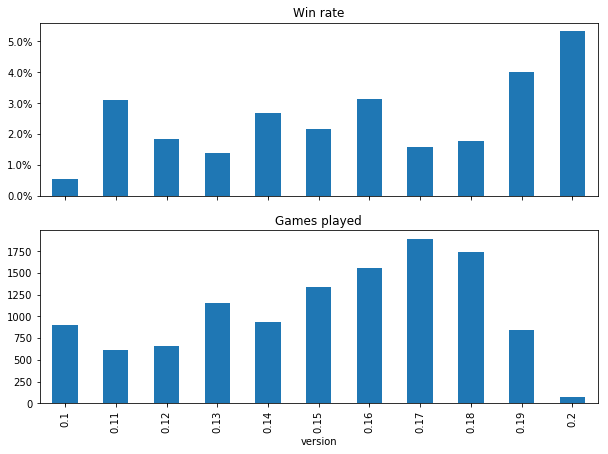

In [117]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,7))
dd_winr = f[f['species'] == 'deep dwarf'].groupby('version')['won'].mean()
dd_plays = f[f['species'] == 'deep dwarf'].groupby('version').size()
plot_percent(dd_winr, ax=ax1, title="Win rate")
dd_plays.plot.bar(ax=ax2, title="Games played");

Nope! Their win rate is actually kinda low in 0.18. Well what if most of these DDs are secretly bots? 

### DD Bots?

It turns out that, as crushingly difficult as DCSS is, there exists at least one bot that can beat it. Elliptic's [qw](https://github.com/elliptic/qw) bot can apparently win 15% of games with its best combination, Deep Dwarf(!) fighter of Makhleb.

qw leaves some distinctive patterns in the notes section. By looking for them, I was able to positively id on the order of 1000 bot games. But I can't be totally certain there don't exist other bots, or variants of qw that don't leave these patterns. 

One hallmark of bots is that they play really fast. Let's plot turns taken against wallclock time, and see if there's a noticeable difference between DDs and non-DDs.

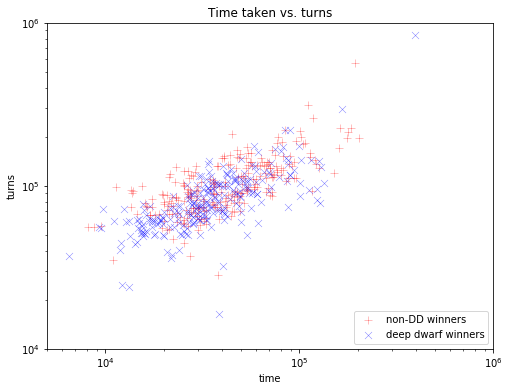

In [119]:
s = 50
alpha = 0.5
n = 250
lw=.5
def plot_turn_time(figsize=(8,6)):
    ax = f.loc[iwon & ~(f['species']=='deep dwarf')].head(n)\
        .plot.scatter(x='time', y='turns', color='red', marker="+", figsize=figsize, loglog=1,
                      label='non-DD winners', alpha=alpha, s=s, lw=lw);
    f.loc[iwon & (f['species']=='deep dwarf')].head(n)\
        .plot.scatter(x='time', y='turns', color='blue', label='deep dwarf winners',
                      marker="x", alpha=alpha, s=s, lw=lw, ax=ax)

    l, r = 5*10**3, 10**6
    b, t = 10**4, 10**6
    ax.set_xlim(l, r)
    ax.set_ylim(b, t)
    ax.legend(loc=4);
    ax.set_title("Time taken vs. turns")
    return ax
plot_turn_time();

(Note the log-log scale, and the truncated axes.)

Looks pretty well mixed. If anything, DDs seem to be a little slower, with respect to turns taken per second.

Just to make it really clear, let's load up some known bot games and add them to the mix.

In [120]:
bots = STORE['bots']
print "Loaded {} games by known bots, {} of which were won ({:.1f}%)".format(
    len(bots), len(bots.loc[iwon]), len(bots.loc[iwon])*100/len(bots)
)
bots.groupby('species').size().sort_values(ascending=0).head(5)

Loaded 1190 games by known bots, 16 of which were won (1.3%)


species
gargoyle      183
deep dwarf    166
minotaur      163
deep elf       86
vampire        58
dtype: int64

DDs are the second most frequent species in known bot games. Interestingly, the win rate is quite low compared to the 10-15% win rate qw claims for good combos. Maybe these games involve lots of experimentation with species/bg combos that are off the golden path, or early versions of the bot that were less proficient. 1.3% is still about twice as good as overall win rate for human players. 

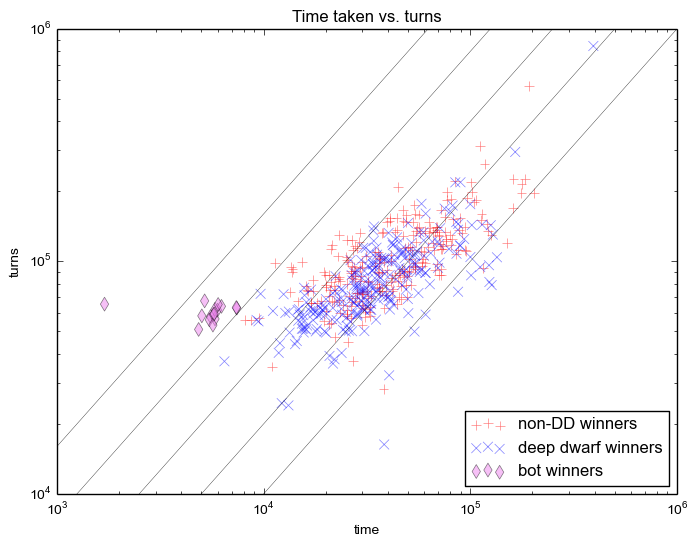

In [376]:
ax = plot_turn_time((8,6))
bots.loc[iwon].head(n)\
    .plot.scatter(x='time', y='turns', color='violet', label='bot winners',
                  marker="d", alpha=alpha, s=s, lw=lw, ax=ax)

l, r = 10**3, 10**6
b, t = 10**4, 10**6
ax.set_xlim(l, r)
ax.set_ylim(b, t)
for turns_per_second in [1, 2, 4, 8, 16]:
    ax.plot(
        [l, t/turns_per_second],
        [l*turns_per_second, t],
        color='black', lw=lw/2,
    )
ax.legend(loc=4);

The diagonal lines represent, from left to right, 16/8/4/2/1 turns taken per second. The bots are clearly in a league of their own here. When they win, they win in a small number of turns and a *really* small amount of time (I had to move the x-axis back to make that one bot with the ~20 minute time visible - it was literally off the chart).

### Newb reppelent?

My best guess is just that deep dwarves are unattractive to inexperienced players. Not being able to regenerate HP is really scary. So DD games are skewed towards experienced players, who are more likely to win (no matter what species they're playing). 

We could try to test this directly, but it'd be tricky. Number of games played is going to be a poor approximation of level of experience, because lots of users will have played DCSS locally (or on another server, or under another username), before playing their first CAO game. 

But this hypothesis is at least partially supported by the earlier chart of species pick rate, which showed DDs as the 4th least pick species. Does a general relationship hold between a species' popularity and its win rate? Let's make a scatterplot!

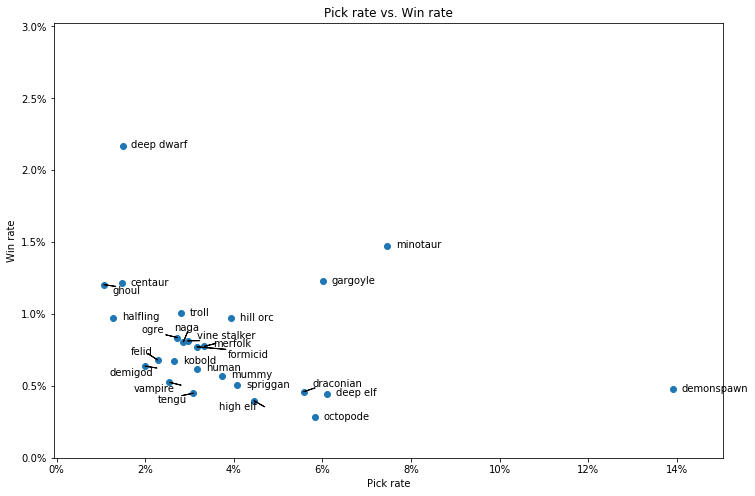

In [139]:
sp = pr.index
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pr.values, wr[sp].values)
# Normally I'd use adjustText (https://github.com/Phlya/adjustText) for this problem of overlapping
# annotations, but I get some inscrutable error when I use it. Some kind of weird interaction with Jupyter
# I guess. God help me if any of these points move after adding new data. :(
RIGHT, LEFT = .1, -1.0
offsets = {'ghoul': (0, -.05), 'draconian': (0, .05), 'ogre': (LEFT, .05), 'felid': (LEFT+.2, .05),
    'vine stalker': (0, .03), 'naga': (RIGHT-.5, .09), 'formicid': (RIGHT+.4, -.06), 'merfolk': (0, .01)}
botleft = ['demigod', 'vampire', 'tengu', 'high elf']
for b in botleft:
    offsets[b] = (LEFT, -.05)
for species in sp:
    x = pr.loc[species]
    y = wr.loc[species]
    dx, dy = offsets.get(species, (0,0))
    dx *= .01
    dy *= .01
    ax.annotate(species, 
                xytext=(x+.002+dx, y-.00015+dy),
                xy=(x,y),
                arrowprops=(dict(facecolor='black', headwidth=.1, width=.1) if (species in offsets) else None)
               )
ax.set_title("Pick rate vs. Win rate")
ax.set_xlabel('Pick rate')
xlabel_pct(ax)
ax.set_ylabel('Win rate');
ax.set_ylim(bottom=0)
ax.set_yticklabels(['{:.1f}%'.format(y*100) for y in ax.get_yticks()]);

There does seem to be a weak correlation here. Demonspawn, the most played class, has a poor win rate. Octopodes, the species with the lowest win rate, is in the top 5 most picked. Centaurs, ghouls, and deep dwarves are very unpopular and win a lot.

The two big exceptions are minotaurs and gargoyles, which are very popular and have a high win rate. 

## Why do octopodes suck?

At around 1 in 400, octopodes have the lowest win rate of any species. 

We could make the claim that, whereas DDs are a newb repellent, Octopodes are a newb magnet. "8 rings? Cool!". And they are quite popular. 

But let's try to dig a bit deeper. How and when do octopodes meet their demise?

In [140]:
# Kinda slow. Probably a more efficient way to do this, without looping. 
# I wish the pandas group by documentation was better.
dr_given_level = [] # TODO: exclude ocs
for lvl in range(1, 28):
    dr_given_level.append( (ilost & (f['level'] == lvl)).sum() / 
                          (0.0+(f['level'] >= lvl).sum()) )

oc_dr_given_level = []
for lvl in range(1, 28):
    oc_dr_given_level.append( (ilost & (f['level'] == lvl) & (f['species'] =='octopode')).sum() / 
                          (0.0+((f['level'] >= lvl) & (f['species'] =='octopode')).sum()) )

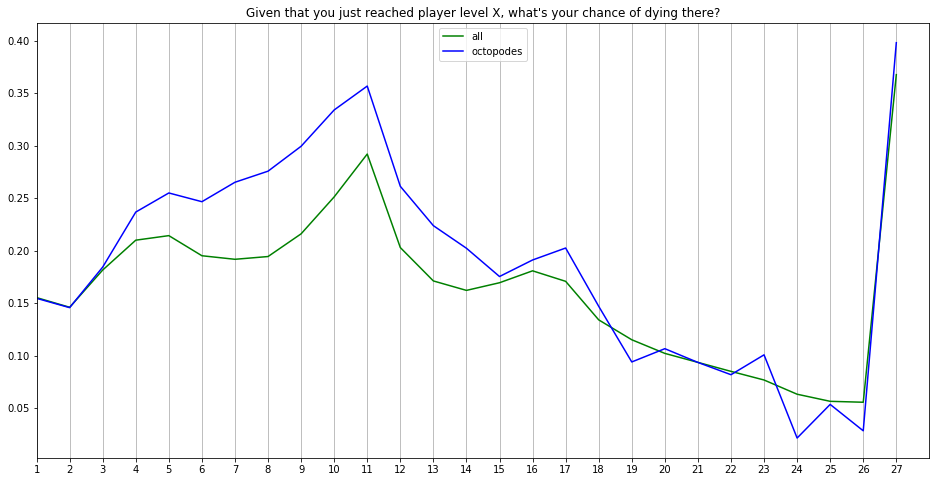

In [143]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.arange(1,28), dr_given_level, color='g', label='all')
ax.plot(np.arange(1,28), oc_dr_given_level, color='b', label='octopodes')
ax.legend(loc=9)
ax.set_xlim(1, 28);
# TODO: Maybe add contour lines for all these lvl plots?
ax.set_xticks(range(1,28))
ax.set_title("Given that you just reached player level X, what's your chance of dying there?");
ax.grid(axis='x')
# Wait, is this consistent with the deaths per plvl plot? Hm, I suppose it is, but the fact
# that it is is kind of surprising and unintuitive.

# The huge spike at level 27 is kind of funny. It's true that level 27 is when most players visit
# the scariest areas in the game: zot, pan, hells, and tomb. But that might just be a red herring 
# - I bet your chance of dying on any given *turn* of level 27 is pretty low - maybe lower than
# any other level. But you spend a lot more turns at level 27 than at any other level, because it's
# the cap, so there are just a lot more opportunities to die there.
# TODO: this is testable

The first three levels are about as deadly for octopodes as for anyone else. But the death rate really diverges at level 4 and doesn't equalize until the mid to late teens. It takes a long time to fill 8 ring slots! 

(Aside: The huge bump at level 11, and the lesser one around 16/17 are both interesting. I think the first bump corresponds to when most players enter the lair, and the second corresponds to when players start venturing into rune branches. I'll go into more of this stuff in another post.)

It's also interesting to look at a counterpart to this: given that you reached level X, what's your chance of winning?

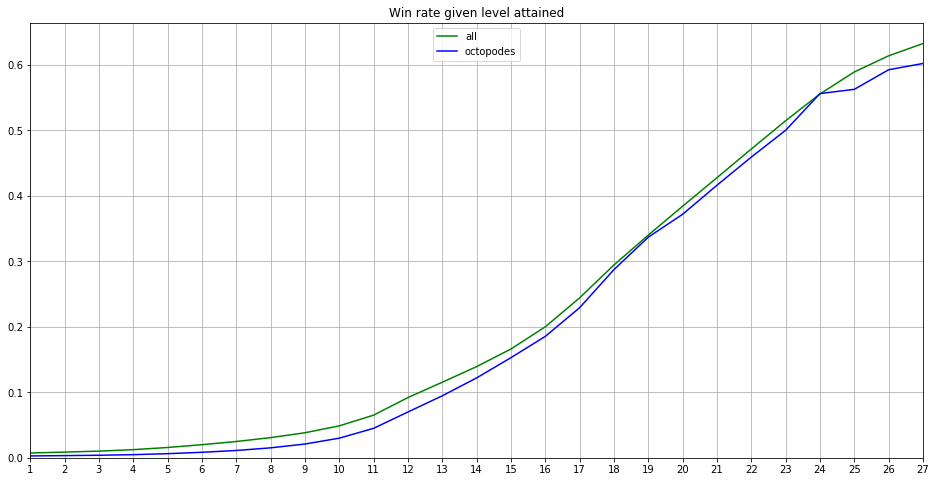

In [150]:
wr_given_level = []
for lvl in range(1, 28):
    wr_given_level.append(f[f['level'] >= lvl]['won'].mean())

oc_wr_given_level = []
for lvl in range(1, 28):
    oc_wr_given_level.append(
        f[(f['level'] >= lvl) & (f['species'] == 'octopode')]['won'].mean()
    )

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(range(1,28), wr_given_level, color='g', label='all')
ax.plot(range(1,28), oc_wr_given_level, color='b', label='octopodes')
ax.legend(loc=9)
ax.set_xlim(1, 27);
ax.set_ylim(bottom=0)
ax.set_xticks(range(1,28))
ax.set_title('Win rate given level attained');
ax.grid(axis='both');

Octopodes' win rate starts low and stays there until the mid game. But if you can survive until level 19, your chance of victory is about the same as a random level 19 adventurer off the street. 

(Their win rate dips below average again after level 25, but proportionally, the difference between 60% and 63% isn't much, compared to .4% vs. 1% at level 3.)

Essentially, octopodes are pretty decent in the mid-to-late game, but frequently die before they can get there. It'd be interesting to see where other species fall on this scale.

## Early-game, mid-game, and late-game species

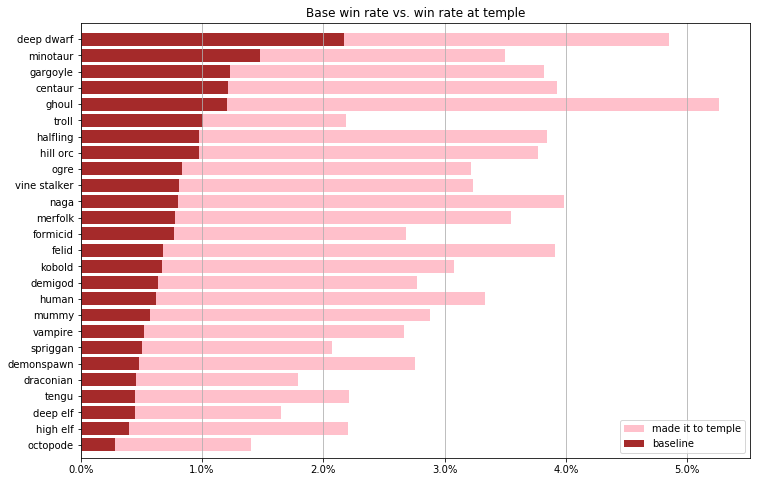

In [173]:
w = .8
fig, ax = plt.subplots(figsize=(12,8))
temple_wr = f[f['saw_temple'] == True].groupby('orig_species')['won']\
 .mean().dropna()[wr.index]
for label, df, color in [('made it to temple', temple_wr, 'pink'), ('baseline', wr, 'brown')]:
    ax.barh(np.arange(len(df.index)), df.values, w, label=label, color=color)
ax.set_ylim(-w, len(wr))
ax.set_yticks(np.arange(len(wr)))
ax.set_yticklabels(wr.index)
xlabel_pct(ax)
ax.set_title("Base win rate vs. win rate at temple")
ax.grid(axis='x')
ax.legend(loc=4);

The brown bars here are our familiar win-rates from before, but the pink bars are new: they show what % of games each species wins *given that it reaches the temple* (a significant early game milestone). 

A disproportionately small pink bar (like the one on trolls), suggests that this species has a strong early game. Getting to the temple doesn't much increase their chance of winning, because they were expecting to make it to the temple. A large pink bar (e.g. ghoul, naga), suggests that going from D:1 to the temple is a significant filter for this species.

Let's throw in a few more milestones: the lair, the vaults, and the realm of zot.

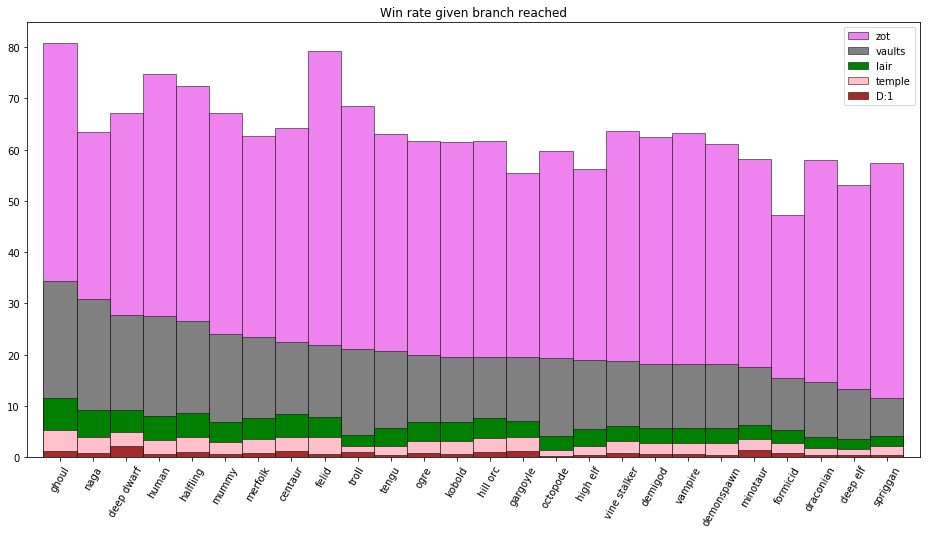

In [197]:
# TODO: clean me up
width = 1
fig, ax = plt.subplots(figsize=(16,8))
colours = ['brown', 'pink', 'green', 'grey', 'violet']
branches = ['D:1', 'temple', 'lair', 'vaults', 'zot']
# Order species by win rate given vaults
sp = f[f['saw_vaults']==True].groupby('orig_species')['won'].mean().sort_values(ascending=0).index
ranked = []
for branch, colour in reversed(zip(branches, colours)):
    if branch == 'D:1':
        df = f
    else:
        df = f[f['saw_'+branch] == True]
    wr = (df.groupby('orig_species')['won'].mean().dropna() * 100)[sp]
    ax.bar(range(len(wr.index)), wr.values, width, label=branch, color=colour,
           linewidth=.5, edgecolor='black',
          )
    ranked.append(wr.sort_values(ascending=0).index)
ranked.reverse()
ax.set_title("Win rate given branch reached")
ax.set_xticks(np.arange(len(wr.index)))
ax.set_xlim(-1, len(wr.index))
ax.set_xticklabels(wr.index, rotation=60)
ax.legend();
# TODO: rotate this?

This time species are sorted by their win rate given that the vaults are reached (the grey bars).

Rather than being dead last, octopodes are around the middle of the pack now. 

Minotaurs have fallen dramatically from rank 2 to 22nd out of 26. This suggests that minotaurs are strong in the early game, and that getting to vaults from the lair isn't much of a filter for them. Nor is getting from vaults to zot. But actually getting through zot (and possibly the extended game) and escaping with the orb is more risky for them, relative to other classes.

The table below might make it easier to see how species go up and down in win rate at different stages of the game - it shows only species' ranking relative to one another.

In [199]:
ranked = np.asarray(ranked).T
# autumn, rainbow, jet
cm = plt.get_cmap('jet')
color_indices = np.linspace(0, 1, ranked.shape[0])
canon_sort = list(ranked.T[0])
alpha = .3
def color_species(sp):
    # I think maybe this can be accomplished with style.background_gradient, but I wrote this before seeing it.
    i = canon_sort.index(sp)
    ctup = cm(color_indices[i])[:-1]
    csstup = tuple(map(lambda x: int(x*255), ctup)) + (alpha,)
    return ';'.join(['background-color: rgba{}'.format(csstup),
                    'text-align: center',
                    'font-size: 16px',
                     'padding: .3em, .6em',
            ])
                              
df = pd.DataFrame(ranked, columns=branches)
s = df.style\
    .applymap(color_species)\
    .set_caption('Species ranked by win rate given milestone reached')
s

Species that move up in rank (like tengu, octopodes, and ghouls), tend to be weak in the early game, and more powerful in the late game.

Species that move down in rank (like spriggans, formicids, minotaurs, and trolls) generally have a more powerful early game.


Another factor that may affect a species' ranking, particularly for the last column, is the number of runes they tend to seek. A species like gargoyles may have a relatively low win rate given that they've seen the entrance to zot, not because they have a weak late game and are in danger of dying in zot, but because they have a high risk of dying in pan or hell, compared to a felid/human/vampire who's probably going for 3 runes.

Let's see at what rate different species head into the extended game. I'll define a game as extended if the player earned more than 5 runes (i.e. they must have got at least one rune from Pan/Hell/Tombs). 

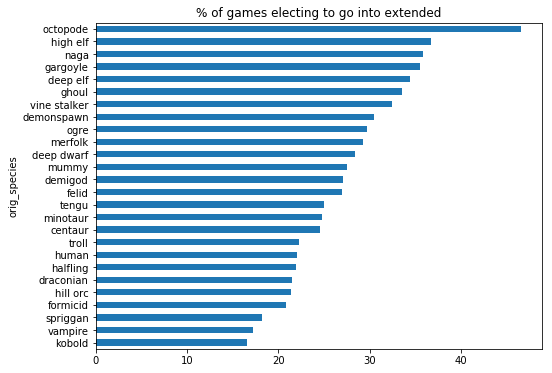

In [201]:
extended = f.loc[f['nrunes'] > 5].groupby('orig_species').size()
(100 * extended / f.loc[f['nrunes'] >= 3].groupby('orig_species').size()).sort_values()\
 .plot.barh(title='% of games electing to go into extended', figsize=(8,6));

The percentages in this chart mean: given that a player of this species earned 3 runes, how likely were they to continue on to earn more than 5 runes?

This may give us some more insight into why octopodes have the lowest overall win rate - they like to fly too close to the sun. Of the games where they get 3 runes, they continue on to get more than 5 runes almost half the time! Presumably there are lots of octopodes who *could* have easily won with 3 runes, but ended up as an ink-blot on the floor of pandemonium. 

In [202]:
octo_death_places = f.loc[ilost & (f['species'] == 'octopode') & (f['saw_zot'])].groupby('wheredied').size()
octo_death_places.name = 'octopodes'
human_death_places = f.loc[ilost & (f['species'] == 'kobold') & (f['saw_zot'])].groupby('wheredied').size()
human_death_places.name = 'kobolds'
dp = pd.concat([octo_death_places, human_death_places], axis=1)
print "Where do octopodes/kobolds die after reaching the entrance to Zot?"
dp.select(lambda i: dp.loc[i].sum() > 3).sort_values(by='octopodes', ascending=0)

Where do octopodes/kobolds die after reaching the entrance to Zot?


,octopodes,kobolds
wheredied,,
ziggurat,20,5
realm of zot,14,41
pandemonium,12,7
pits of slime,10,6
tomb of the ancients,8,5
abyss,4,3
tartarus,4,1
dungeon,3,3
vaults,3,7


A higher % of kobolds who make it to Zot will win than octopodes, but the kobolds who fail to win from that position mostly die in Zot trying to get the orb. The octopodes who fail to win from that point mostly die in exotic extended game locales like ziggurats.

## Which draconian colour is best?

When draconians reach level 7, they're assigned one of 9 colours, each of which has different skill aptitudes, and a unique breath ability. There has been some debate on the forums about which colour is best:

- [Rank the draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=5&t=10176&p=140405)
- [Tier list: Draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=17&t=19271&p=261183)
- [Buff certain draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=8&t=20683&p=279050)

Let's see if we can use data to answer this question.

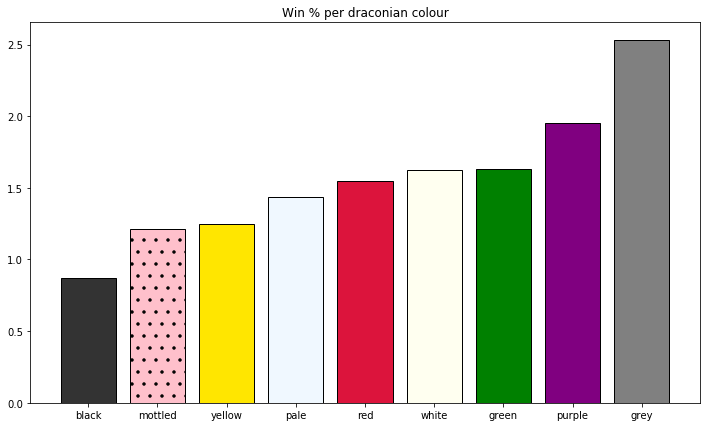

In [205]:
fig, ax = plt.subplots(figsize=(12,7))
# TODO: brittle if ordering changes in the future
colours = [(.2,.2,.2), 'pink', (1,.9,0), 'aliceblue', 'crimson', 'ivory', 'green', 'purple', 'grey']
color_winrates = (f[cdrac_index].groupby('species')['won'].mean().dropna() * 100).sort_values()
xrange = np.arange(len(colours))
labels = [name.split()[0] for name in color_winrates.index]
bars = ax.bar(xrange, color_winrates.values, 
               color=colours, tick_label=labels, 
              edgecolor='black', lw=1,
              )
bars[1].set_hatch('.')
ax.set_title('Win % per draconian colour');

\#justiceforblackdraconians

## Epilogue: dungeon crawl statistical sermon

Those differences look pretty dramatic. A random grey draconian game from our dataset is about 3 times as likely to end in victory as a black one. But maybe the variations are just noise as a result of small sample size. How many draconian games do we have anyways?

In [206]:
games = f[cdrac_index].groupby('species').size()[colored_dracs].rename('games played')
wins = f.loc[cdrac_index & iwon].groupby('species').size()[colored_dracs].rename('games won')
pct = (100 * wins/games).rename('win %')
drac_table = pd.concat([games, wins, pct], axis=1).sort_values('win %', ascending=0)
dt2 = drac_table.copy()
dt2.index = dt2.index.astype('object')
dt2 = dt2.append(drac_table.sum().rename('Overall'))
ov = dt2.loc['Overall']
ov['win %'] = ov['games won'] * 100 / ov['games played']
cdrac_wr = ov['win %'] / 100
dt2
# TODO: number formatting

,games played,games won,win %
species,,,
grey draconian,1384.0,35.0,2.528902
purple draconian,1384.0,27.0,1.950867
green draconian,1410.0,23.0,1.631206
white draconian,1477.0,24.0,1.624915
red draconian,1487.0,23.0,1.546738
pale draconian,1395.0,20.0,1.433692
yellow draconian,1443.0,18.0,1.247401
mottled draconian,1481.0,18.0,1.215395
black draconian,1490.0,13.0,0.872483


That's a lot of games, but the number of victories per colour is pretty small. So are these differences statistically significant? Let's math!

Our null hypothesis here is that the probability of winning the game is equal for all draconian colours. 

### Using the binomial test

Let's imagine the true probability of winning for any colour of draconian is just the average win rate over all colours in our sample (1.55%). Assuming this is the case, what's the chance that, when sampling ~1400 games, we get a win rate as low as 0.9% or as high as 2.5%? The [binomial test](https://en.wikipedia.org/wiki/Binomial_test) gives us an exact answer to this question.

In [18]:
from scipy.stats import binom_test

def binom_pvalue(row):
    played, won = row[['games played', 'games won']]
    return binom_test(won, played, cdrac_wr, alternative='two-sided')

drac_table.apply(lambda d: binom_pvalue(d), axis=1).rename('p-value').to_frame()

,p-value
species,
grey draconian,0.006143
purple draconian,0.230072
green draconian,0.746647
white draconian,0.752446
red draconian,1.000000
pale draconian,0.828334
yellow draconian,0.394822
mottled draconian,0.343596
black draconian,0.035014


So under our null hypothesis, the chances of randomly observing a win rate as extreme as those of grey or black draconians are .6% and 3.5%, respectively. If we choose a typical significance level of 5%, then **these are good enough to call significant**. The other colours, however, don't meet that significance threshold.

But there's a problem here. The chance of any given group having a significant p-value given the null hypothesis is 5%, but I tested *nine* groups. The more hypotheses I test, the greater the chance that one will produce a false positive ([relevant xkcd](https://xkcd.com/882/)). 

A really simple mitigation is the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), which just cuts the significance threshold for each of n tests down to 1/nth of the desired overall significance level. With a new threshold of .05 / 9 ~= 0.006, even grey draconians' p-value fails to make the cut. 

But let's not lose hope. The Bonferonni correction is a pretty blunt tool, but also, the hypothesis we're testing against is maybe stronger than it needs to be. Our original null hypothesis was just that the win rates of all draconian colours are the same, *not* that the win rates of all draconian colours are equal to the overall draconian sample mean that we measured at 1.55%.

**TODO: well, this was fun to think about, but I'm not sure it actually amounted to anything. Does this make any difference under reasonable assumptions? What if we have some unusual priors about the overall population mean? I guess it sort of comes down to how P(color_wins_and_losses | wr) and P(wr) vary together. Maaaath.
Keywords: Bayes, monte carlo, https://lingpipe-blog.com/2009/09/11/batting-averages-bayesian-vs-mle-estimate/
**

So rather than calculating grey draconians' p-value as

    prob(>=35 games won out of 1384 | winrate=.0155)
    
What we'd really like is to take the integral of that function over all win rates `p` from 0 to 1, weighted by a suitable prior on `p` (a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) having α = 202, β = 12952 is a good representation of where we would expect the overall win rate to fall, given the wins and losses in our sample).

It turns out this kind of compound distribution is common enough to have a name and a Wikipedia article: it's a [beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution). It looks like our scary integral might actually be tractable, but there's no implementation in Scipy, and we're really getting into the weeds at this point. Let's try something else.

### Using the chi-squared test

[Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) can equivalently(?) be thought of as testing any of the following null hypotheses:

1. Our per-colour samples are homogeneous
2. Colour is independent of win rate
3. The overall observed draconian win rate is a good approximation of each colour's true win rate. (**XXX: I have a hard time with this one.**)

Chi-squared tests assume the data being considered is normally distributed, which is [asymptotically true](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) for our binomially distributed data. (That Wikipedia section gives some rules of thumb for whether the normal approximation is appropriate, which our data conform to.)
    
A nice aspect of this test is that we don't need to worry about doing anything like the Bonferroni correction with it. Whereas before we separately tested 9 hypotheses ("Do grey draconians win significantly more?", "Do purple draconians win significantly more?", ...), now we're applying one test to all the data to test one hypothesis: are there any significant differences in win rate among colours?

In [207]:
from scipy.stats import chi2_contingency

chi2, p, dof, _ = chi2_contingency(
    drac_table[ ['games played', 'games won']].values
)
print "chi^2 = {}\tp-value = {}\tdegrees of freedom={}".format(chi2, p, dof)

chi^2 = 16.2369804875	p-value = 0.0391110953608	degrees of freedom=8


Significant!

This doesn't tell us *which* groups differ significantly from the overall mean, or which pairs of colours differ significantly from one another. For the former, the p-values per colour that we calculated previously probably serve as a pretty good key to sort on. But the latter is tricky to do in a principled way.

### Comparing colours pair-wise

A [z-test](https://people.richland.edu/james/lecture/m113/two_proportions.html) is a simple way to test whether two colours differ significantly. Maybe we could perform z-tests on neighbouring pairs from lowest to highest win rate ({Black, Mottled}, {Mottled, Yellow},...) and do a Bonferroni correction to account for our 8 comparisons? Or we could look for the most dramatic differences, starting by comparing Black and Grey, and telescoping in closer to the middle until we stopped getting significant differences?

But wait, I'm doing something underhanded here: [Testing hypotheses suggested by the data](https://en.wikipedia.org/wiki/Testing_hypotheses_suggested_by_the_data). I'm choosing which pairs of colours to compare based on that nice bar graph I made. In some sense, my p-values should probably be adjusted according to the number of tests I'd need to do to find a given effect *without being guided by snooping the data*. So should I divide my p-values by the number of pairs (~n^2)?

Bonferroni has the nice properties of being simple and working everywhere, but it can be overly conservative. Fortunately there are some more powerful methods, using the [Studentized range distribution](https://en.wikipedia.org/wiki/Studentized_range_distribution), which are tailored to this specific problem. Unfortunately, they're kind of complicated, and I got a C- in stats.  So let's just add some quick-and-dirty error bars and call it a day.

Wikipedia describes at least [seven](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) methods for calculating confidence intervals for binomial proportions. None of them have scipy oneliners, so I took the first code snippet I found on [StackOverflow](http://stackoverflow.com/a/24023800/262271) that looked like it wasn't trying to steal my credit card information. (It implements the [Wilson score interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval)).

Let's use it to calculate 95% confidence intervals for each win rate, and plot them as error bars.


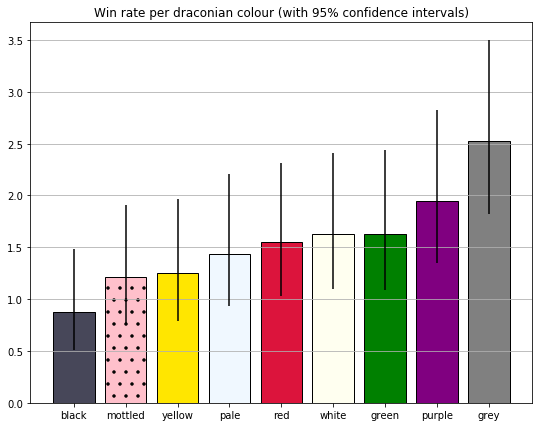

In [208]:
from bin_conf import binconf

err_low = drac_table.apply(
    lambda row: binconf(row['games won'], (row['games played']-row['games won']), c=.95)[0],
    axis=1) * 100
err_high = drac_table.apply(
    lambda row: binconf(row['games won'], (row['games played']-row['games won']), c=.95)[1],
    axis=1) * 100
cwr = color_winrates
# matplotlib wants offsets, not positions
err_low = color_winrates - err_low[cwr.index]
err_high = err_high[cwr.index] - color_winrates

fig, ax = plt.subplots(figsize=(9,7))
# TODO: brittle if ordering changes in the future
colours = [(.28,.28,.35), 'pink', (1,.9,0), 'aliceblue', 'crimson', 'ivory', 'green', 'purple', 'grey']
cdrac_index = f['species'].isin(colored_dracs)
color_winrates = (f[cdrac_index].groupby('species')['won'].mean().dropna() * 100).sort_values()
xrange = np.arange(len(colours))
labels = [name.split()[0] for name in color_winrates.index]
bars = ax.bar(xrange, color_winrates.values, 
               color=colours, tick_label=labels, 
              edgecolor='black', lw=1,
              yerr=[err_low[color_winrates.index].values, err_high[color_winrates.index].values],
              )
bars[1].set_hatch('.')
ax.set_title('Win rate per draconian colour (with 95% confidence intervals)');
ax.grid(axis='y');

These (pretty huge) error bars span a range that we can be 95% confident contains the true win rate for a given colour. 

Based on this, we can at least be pretty confident of a significant difference between grey and black, but not of much else.

**TODO: Actually, so for any colour there's a 5% chance the true mean is outside the range of the error bar. For simplicity, we can say there's a 2.5% chance of it being under/over. So the probability that, say, black and grey draconians have the same win rate isn't just like 5%. It should be less than .025^2 = .0006%! Teensy. Okay, so how do we use these bars in general to make inferences about how likely two colours are to differ significantly? (with the caveat of multiple comparisons pushed aside for now)**

**Can I choose a (smaller) interval size for each colour such that the probability of two colours having the same win rate given that their err-bars don't overlap *is* bounded by 5%, or any other desired threshold?**